# Stochastic Gradient Langevin Dynamics II: Replica Exchange SGLD

As shown in the previous demo, with only one chain generated, if the temperature of the chain is too high, the sampled $x$ reach the global minimum quickly but keeps jumping around afterwards (because the noise term is too much). If the temperature is low, the sampled $x$ could get very unlucky and discover the global minimum very late, but it will stay relatively close to the minimum afterwards. One way to combine the benefits of high and low temperatures is to simulate two chains of Langevin dynamics at the same time, and allowing the two chains to "communicate" with each other.

Let us start by using the exact gradient.

In [1]:
# general imports
import numpy
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Exact Gradient reLD

With exact gradient, the replica exchange LD is defined as two chains:

$$
    x_{k+1}^{(1)} = x_k^{(1)} - s_k \nabla U(x_k^{(1)}) + \sqrt{2 s_k \tau_1}\xi_k^{(1)} \\
    x_{k+1}^{(2)} = x_k^{(2)} - s_k \nabla U(x_k^{(2)}) + \sqrt{2 s_k \tau_2}\xi_k^{(2)} \\
$$

$\tau_1$ and $\tau_2$ are two different temperatures, with $\tau_1 < \tau_2$.

The method with which they communicate is swapping, by which we mean
$$
    x_{h+1}^{(1)} = x_h^{(2)} \text{ and } x_{h+1}^{(2)} = x_h^{(1)}
$$ 

With each update, the swapping probability is $a \min{\{1, \exp{[\tau_{\delta}(U(x_h^{(1)}) - U(x_h^{(2)}))]}\}}$, where $\tau_{\delta} = \frac{1}{\tau_1} - \frac{1}{\tau_2}$

Let us simulate this process with the multimodal function we defined before. $$f(x) = x^2 - \cos(\pi x) + x$$ $$f'(x) = 2x + \pi \sin(\pi x) + 1$$

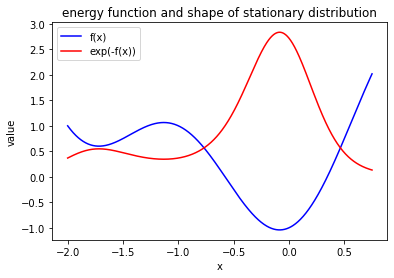

In [2]:
x = numpy.linspace(-2, 0.75, 1000)
f = lambda x : x**2 - numpy.cos(numpy.pi*x) + x
f_prime = lambda x : 2*x + numpy.pi * numpy.sin(numpy.pi*x) + 1

# plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, f(x), 'b', label = "f(x)")
ax.plot(x, numpy.exp(-f(x)), 'r', label = "exp(-f(x))")
ax.set_xlabel("x")
ax.set_ylabel("value")
ax.set_title("energy function and shape of stationary distribution")
ax.legend()
plt.show()

We define the reLD scheme and run it. First we plot the distributions of the two chains together.

In [3]:
# setup and conditions:
n = 1000
s_log_sq = lambda x : 1 / (numpy.log(2*x+1)+5)**2
t_1 = 0.25
t_2 = 2
guess = -1.3


def reLD(f, f_prime, N, temp_1, temp_2, step, x_0, a, limit = None):
    '''
    Parameters:
     N: number of iterations
     temp: temperature of iteration
     step: step size, as a function of iteration count, must go to zero
     x_0: initial guess
     limit: a range optinally enforced on x; if x is out of range, then it's forced to the lower or upper bound
     
    Returns: two numpy arrays of sampled x's
    '''
    
    chain_1 = numpy.empty(N)
    chain_2 = numpy.empty(N)
    chain_1[0] = x_0
    chain_2[0] = x_0
    swap_count = 0
    swap_idx = []
    
    for i in range(N-1):
        tau_del = (1 / temp_1) - (1 / temp_2)
        p = numpy.exp(tau_del*(f(chain_1[i]) - f(chain_2[i])))
        if i < 10:
            print(p)
        p_swap = a * step(i) * min([1, p])
        rand = numpy.random.uniform(0,1)
        if rand <= p_swap:
            chain_1[i+1] = chain_2[i]
            chain_2[i+1] = chain_1[i]
            #print("Swap occured.")
            swap_count += 1
            swap_idx.append(i)
        else:
            chain_1[i+1] = chain_1[i] - f_prime(chain_1[i]) * step(i) + numpy.sqrt(2 * step(i) * temp_1) * \
                           (numpy.random.normal(0,1))
            chain_2[i+1] = chain_2[i] - f_prime(chain_2[i]) * step(i) + numpy.sqrt(2 * step(i) * temp_2) * \
                           (numpy.random.normal(0,1))
        if limit != None:
            if  x_new > limit[1]:
                x_new = limit[1]
            elif x_new < limit[0]:
                x_new = limit[0]
        
    
#         if i < 100:
#             print(x_sgd[i])
    print("Swap occurred {n} times".format(n=swap_count))
    
    return (chain_1, chain_2, swap_idx)

# run SGLD
res_1, res_2, swaps = reLD(f, f_prime, n, temp_1 = t_1, temp_2 = t_2, step = s_log_sq, x_0 = guess, a = 0.75)



1.0
3.681217014192657
3.161233808477381
4.432673171783582
2.845357562726655
0.03851437682653865
3.2704450594263634
0.00044592047823696575
0.19615953517156462
1.6233232487693783
Swap occurred 1 times


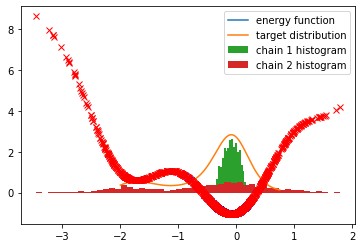

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, f(x), label = "energy function")
ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
ax.hist(res_1, bins = 50, density = True, label = "chain 1 histogram")
ax.plot(res_1, f(res_1), 'bx')
ax.hist(res_2, bins = 50, density = True, label = "chain 2 histogram")
ax.plot(res_2, f(res_2), 'rx')
ax.legend()
plt.show()

Now we plot the two chains seperately. Chain 1 has the lower temperature. We remark that on average, with replica exchange, even the low temperature chain finds the global minimum quite fast (within in 100-200 iterations), and the distribution concentrates that afterwards. Chain 2, the high temp chain, has a pretty spread-out distribution.

Note that in the following graphs (not only in this section), if a swap occurs during a time period, the swap is marked as follows: position before swap in black, position after swap in red.

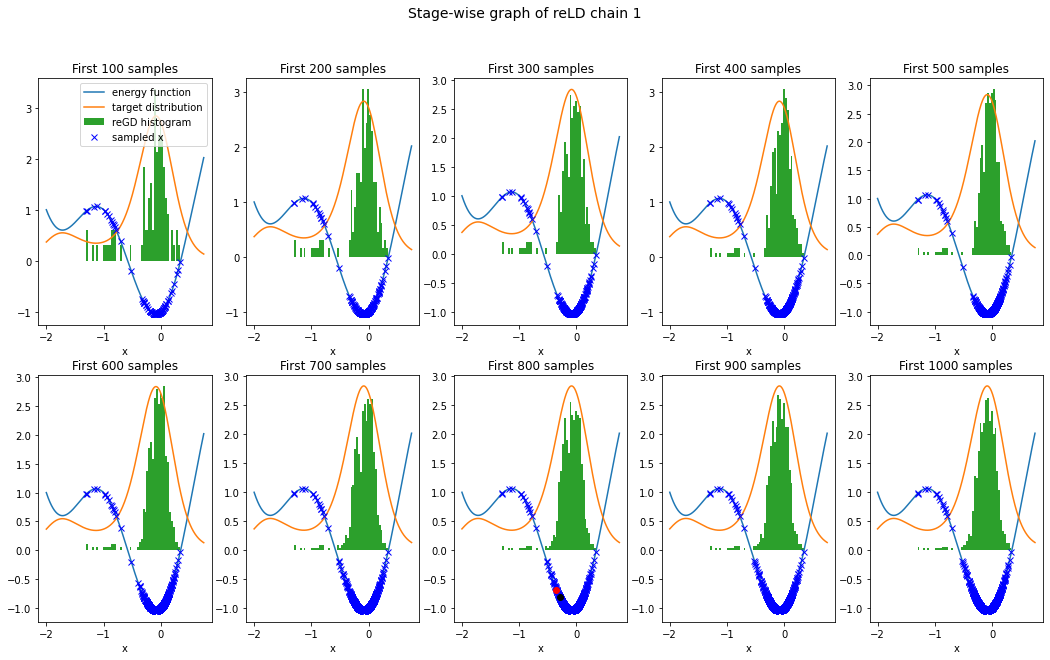

Swap occured at i = : [751]


In [5]:
fig = plt.figure(figsize=(18, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.plot(x, f(x), label = "energy function")
    ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
    ax.hist(res_1[:len(res_1)*(i+1)//10], bins = 50, density = True, label = "reGD histogram")
    #the line below is most useful for small number of iterations
    ax.plot(res_1[:len(res_1)*(i+1)//10], f(res_1[:len(res_1)*(i+1)//10]), 'bx', label = "sampled x")
    for idx in swaps:
        if idx < len(res_1)*(i+1) // 10 and idx >= len(res_1)*(i) // 10:
            ax.plot(res_1[idx], f(res_1[idx]), 'ko')
            ax.plot(res_1[idx+1], f(res_1[idx+1]), 'ro')
    if i == 0:
        ax.legend()
    ax.set_xlabel("x")
    ax.set_title("First {n} samples".format(n=len(res_1)*(i+1)//10))
fig.suptitle("Stage-wise graph of reLD chain 1", fontsize=14)
plt.show()
print("Swap occured at i = :", swaps)

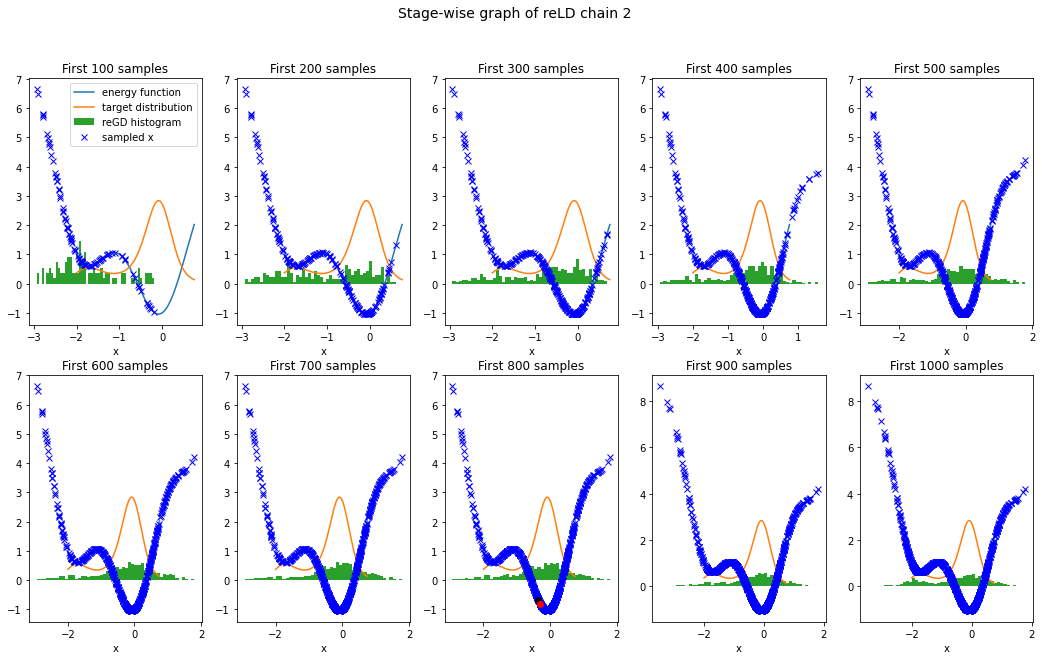

Swap occured at i = : [751]


In [6]:
fig = plt.figure(figsize=(18, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.plot(x, f(x), label = "energy function")
    ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
    ax.hist(res_2[:len(res_2)*(i+1)//10], bins = 50, density = True, label = "reGD histogram")
    #the line below is most useful for small number of iterations
    ax.plot(res_2[:len(res_2)*(i+1)//10], f(res_2[:len(res_2)*(i+1)//10]), 'bx', label = "sampled x")
    for idx in swaps:
        if idx < len(res_2)*(i+1) // 10 and idx >= len(res_2)*(i) // 10:
            ax.plot(res_2[idx], f(res_2[idx]), 'ko')
            ax.plot(res_2[idx+1], f(res_2[idx+1]), 'ro')
    if i == 0:
        ax.legend()
    ax.set_xlabel("x")
    ax.set_title("First {n} samples".format(n=len(res_2)*(i+1)//10))
fig.suptitle("Stage-wise graph of reLD chain 2", fontsize=14)
plt.show()
print("Swap occured at i = :", swaps)

To compare, we run two single Langevin dynamics chains (without replica exchange) at the same temperatures, low and high respectively. Of course, there are a lot of variations across each time we run the simulation, but in general we remark the following:

- the low temp single chain could find the global minimum faster, but if the first few iterations are stuck at the other sub-optimal valley, it stays there longer before reaching the global minimum.
- the high temp chain is still quite spread out.

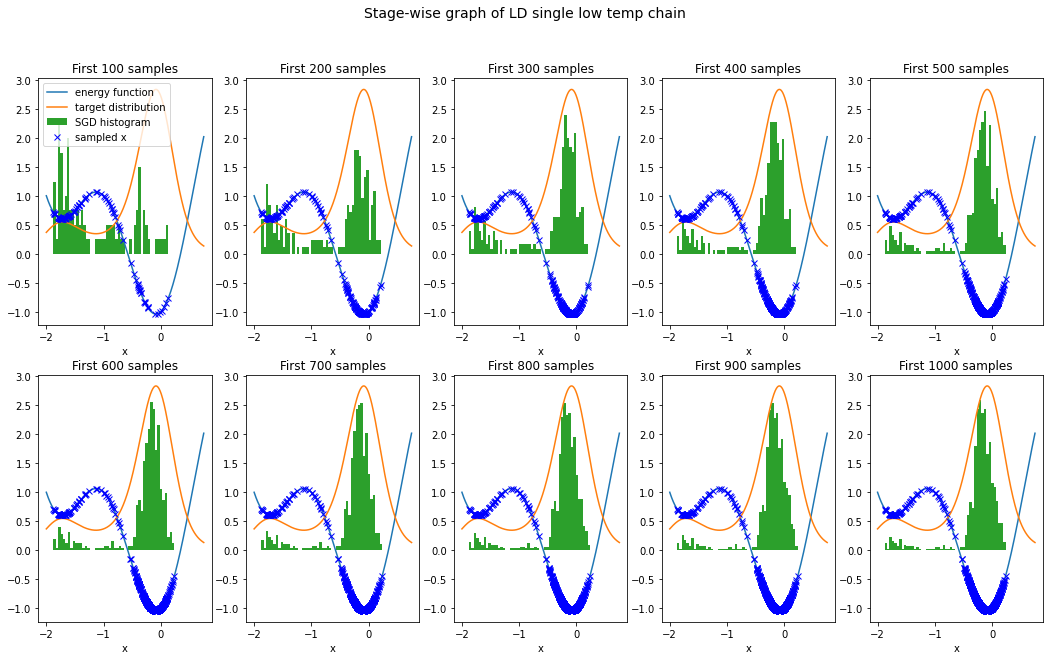

In [7]:
# compare with usual one-chain

def sgld(f, f_prime, N, temp, step, x_0, limit = None):
    '''
    Parameters:
     N: number of iterations
     temp: temperature of iteration
     step: step size, as a function of iteration count, must go to zero
     x_0: initial guess
     limit: a range optinally enforced on x; if x is out of range, then it's forced to the lower or upper bound
     
    Returns: a numpy array of sampled x's
    '''
    
    x_sgd = numpy.empty(N)
    x_sgd[0] = x_0
    
    for i in range(N-1):
        x_new = x_sgd[i] - f_prime(x_sgd[i]) * step(i) + numpy.sqrt(2 * step(i) * temp) * (numpy.random.normal(0,1))
        if limit != None:
            if  x_new > limit[1]:
                x_new = limit[1]
            elif x_new < limit[0]:
                x_new = limit[0]
        x_sgd[i+1] = x_new
    
#         if i < 100:
#             print(x_sgd[i])
    
    return x_sgd



# run SGLD
result = sgld(f, f_prime, n, temp = t_1, step = s_log_sq, x_0 = guess)

# stage-wise plotting
fig = plt.figure(figsize=(18, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.plot(x, f(x), label = "energy function")
    ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
    ax.hist(result[:len(result)*(i+1)//10], bins = 50, density = True, label = "SGD histogram")
    #the line below is most useful for small number of iterations
    ax.plot(result[:len(result)*(i+1)//10], f(result[:len(result)*(i+1)//10]), 'bx', label = "sampled x")
    if i == 0:
        ax.legend()
    ax.set_xlabel("x")
    ax.set_title("First {n} samples".format(n=len(result)*(i+1)//10))
fig.suptitle("Stage-wise graph of LD single low temp chain", fontsize=14)
plt.show()

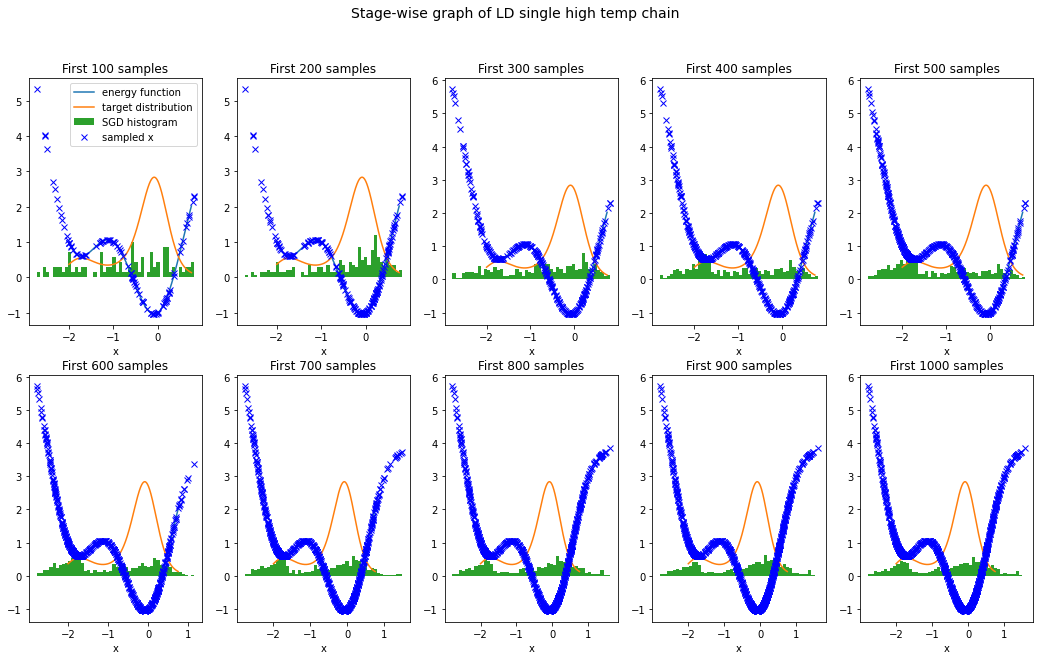

In [8]:
result = sgld(f, f_prime, n, temp = t_2, step = s_log_sq, x_0 = guess)

# stage-wise plotting
fig = plt.figure(figsize=(18, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.plot(x, f(x), label = "energy function")
    ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
    ax.hist(result[:len(result)*(i+1)//10], bins = 50, density = True, label = "SGD histogram")
    #the line below is most useful for small number of iterations
    ax.plot(result[:len(result)*(i+1)//10], f(result[:len(result)*(i+1)//10]), 'bx', label = "sampled x")
    if i == 0:
        ax.legend()
    ax.set_xlabel("x")
    ax.set_title("First {n} samples".format(n=len(result)*(i+1)//10))
fig.suptitle("Stage-wise graph of LD single high temp chain", fontsize=14)
plt.show()

## 2. Stochastic Gradient LD (SGLD)

The "stochastic" gradient LD uses a non-exact gradient and a non-exact energy function, following a distribution around the true gradient. In reality, it could be hard to find the exact gradient, but an estimator of the gradient. In this setting, we simulate this randomness by calculating the exact gradient first, and then generating a random sample from a normal distribution centered around the true gradient. The variance of that distribution will play a role in some simulation methods. We will simulate random noise in the evaluation of energy functions in the same manner.

The update scheme in Deng et al. (2020) is as follows:

$$
    \hat{\theta}_{k+1}^{(1)} = \hat{\theta}_k^{(1)} - \eta_k \hat{\nabla U}(\theta_k^{(1)}) + \sqrt{2 \eta_k \tau_1}\xi_k^{(1)} \\
    \hat{\theta}_{k+1}^{(2)} = \hat{\theta}_k^{(2)} - \eta_k \hat{\nabla U}(\theta_k^{(2)}) + \sqrt{2 \eta_k \tau_2}\xi_k^{(2)} \\
$$

where $\xi_k^{(1)}$ and $\xi_k^{(2)}$ independently follow the standard normal distribution. In our implementation below, $\hat{\nabla U} \sim N(\nabla U, \sigma_{grad} ^2)$. Deng et al. proposed the following swapping rate using an energy function estimator $\hat{U} \sim N(U, \sigma_{U}^2)$:

$$
    p(swap) = a \min{\{1, \exp{[\tau_{\delta}(\hat{U}(x_h^{(1)}) - \hat{U}(x_h^{(2)})-\tau_{\delta}\sigma_{U}^2)]}\}}
$$

In [9]:
def reSGLD(f, f_prime, N, temp_1, temp_2, step, x_0, a = 0.5, sigma_u = 1, sigma_grad = 1, limit = None):
    '''
    Applies reSGLD on designated function
    
    Parameters:
     f: energy function
     f_prime: gradient of energy function
     N: number of iterations
     temp_1: used for low temperature chain
     temp_2: used for high temperature chain
     step: step size, as a function of iteration count, must go to zero
     x_0: initial guess
     limit: a range optinally enforced on x; if x is out of range, then it's forced to the lower or upper bound
     a: parameter relating to swapping probability of the two chains, default 0.5
     sigma_u: standard deviation used for energy function estimator, default 1
     sigma_grad: standard deviation used for gradient estimator, default 1
     
    Returns: two numpy arrays of sampled x's, and an array of indices where swap occurred
    '''
    
    chain_1 = numpy.empty(N)
    chain_2 = numpy.empty(N)
    chain_1[0] = x_0
    chain_2[0] = x_0
    swap_count = 0
    swap_idx = []
    
    for i in range(N-1):
        tau_del = (1 / temp_1) - (1 / temp_2)
        p = numpy.exp(tau_del*(numpy.random.normal(f(chain_1[i]), sigma_u) - \
                               numpy.random.normal(f(chain_2[i]), sigma_u) - tau_del * (sigma_u**2)))
        p_swap = a * step(i) * min([1, p])
        if i < 10:
            print(p_swap)
        rand = numpy.random.uniform(0,1)
        if rand <= p_swap:
            chain_1[i+1] = chain_2[i]
            chain_2[i+1] = chain_1[i]
            #print("Swap occured.")
            swap_count += 1
            swap_idx.append(i)
        else:
            chain_1[i+1] = chain_1[i] - numpy.random.normal(f_prime(chain_1[i]), sigma_grad) * step(i) + \
                           numpy.sqrt(2 * step(i) * temp_1) * (numpy.random.normal(0,1))
            chain_2[i+1] = chain_2[i] - numpy.random.normal(f_prime(chain_2[i]), sigma_grad) * step(i) + \
                           numpy.sqrt(2 * step(i) * temp_2) * (numpy.random.normal(0,1))
        if limit != None:
            if  x_new > limit[1]:
                x_new = limit[1]
            elif x_new < limit[0]:
                x_new = limit[0]
        
    
#         if i < 100:
#             print(x_sgd[i])
    print("Swap occurred {n} times".format(n=swap_count))
    
    return (chain_1, chain_2, swap_idx)

sgres_1, sgres_2, swaps_sg = reSGLD(f, f_prime, n, temp_1 = t_1, temp_2 = t_2, step = s_log_sq, x_0 = guess, a = 5)



3.345064345449218e-10
0.005935441832740207
4.460447055733261e-09
9.959262749821496e-07
1.3034248901502632e-05
1.4208459232321972e-06
1.4234259944290147e-08
1.1462009934894666e-07
2.1839646238199368e-08
1.3024776729450975e-07
Swap occurred 1 times


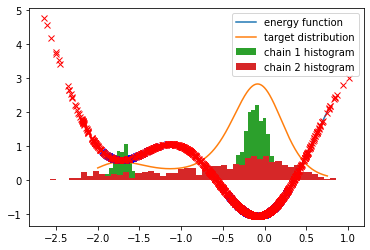

In [10]:
#define a plotting function for later use
def plot_two_chains(interval, f, chain_1, chain_2):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(interval, f(interval), label = "energy function")
    ax.plot(interval, numpy.exp(-f(interval)), label = "target distribution")
    ax.hist(chain_1, bins = 50, density = True, label = "chain 1 histogram")
    ax.plot(chain_1, f(chain_1), 'bx')
    ax.hist(chain_2, bins = 50, density = True, label = "chain 2 histogram")
    ax.plot(chain_2, f(chain_2), 'rx')
    ax.legend()
    plt.show()
    
plot_two_chains(x, f, sgres_1, sgres_2)

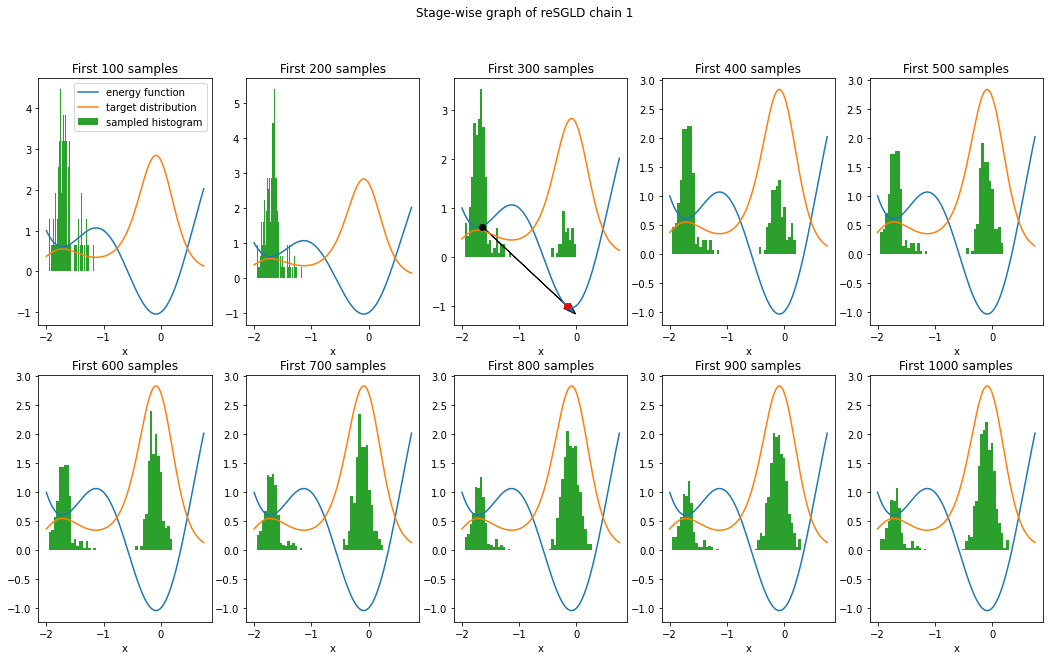

Swap occured at i = : [252]


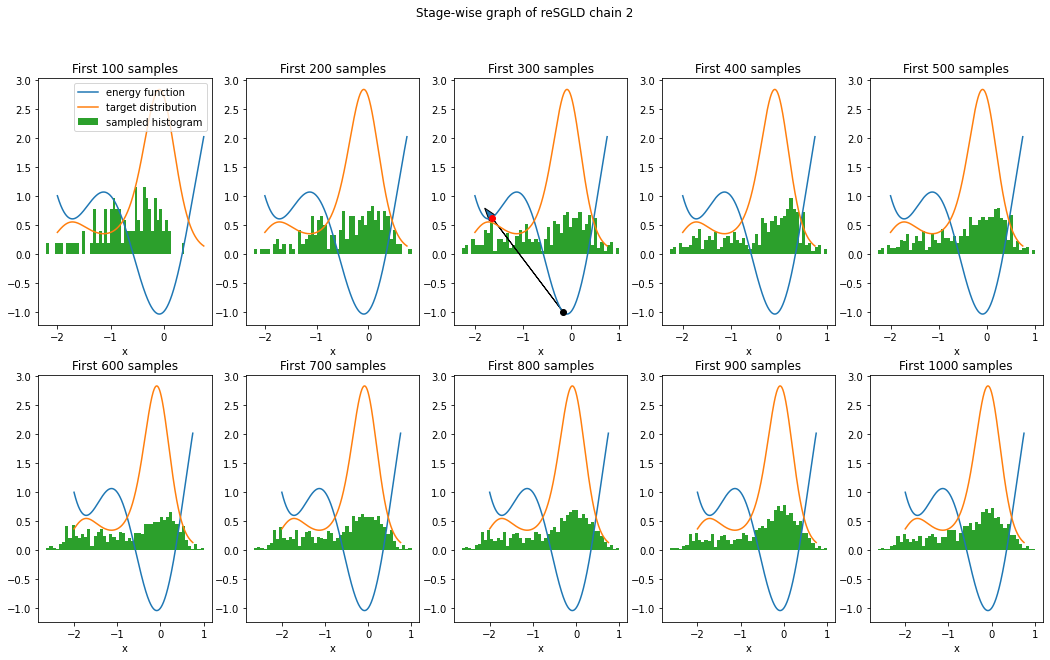

Swap occured at i = : [252]


In [11]:
def single_chain_stagewise_graph(x, f, chain, title, swaps = None):
    """
    Parameters:
    x: interval in which the function is plotted
    f: the function on which LD was done
    chain: result of samples from the algorithm
    title: name of algorithm, see code below
    swaps: a list of indices where two chains swapped, optional
    """
    
    fig = plt.figure(figsize=(18, 10))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1)
        ax.plot(x, f(x), label = "energy function")
        ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
        ax.hist(chain[:len(chain)*(i+1)//10], bins = 50, density = True, label = "sampled histogram")
        #the line below is most useful for small number of iterations
        #ax.plot(chain[:len(chain)*(i+1)//10], f(chain[:len(chain)*(i+1)//10]), 'bx', label = "sampled x")
        if swaps != None:
            for idx in swaps:
                if idx < len(chain)*(i+1) // 10 and idx >= len(chain)*(i) // 10:
                    ax.plot(chain[idx], f(chain[idx]), 'ko')
                    ax.plot(chain[idx+1], f(chain[idx+1]), 'ro')
                    dx = chain[idx+1] - chain[idx]
                    dy = f(chain[idx+1]) - f(chain[idx])
                    ax.arrow(chain[idx], f(chain[idx]), dx, dy, head_width = 0.15)
        if i == 0:
            ax.legend()
        ax.set_xlabel("x")
        ax.set_title("First {n} samples".format(n=len(chain)*(i+1)//10))
    fig.suptitle("Stage-wise graph of {t}".format(t = title, fontsize=14))
    plt.show()
    if swaps != None:
        print("Swap occured at i = :", swaps)

single_chain_stagewise_graph(x, f, sgres_1, "reSGLD chain 1", swaps_sg)
single_chain_stagewise_graph(x, f, sgres_2, "reSGLD chain 2", swaps_sg)